# Heart disease: Spotting heart diseases of patients in Cleveland from different indicators.

Heart disease, or cardiovascular disease, is primarily caused by clogged blood vessels, making it difficult for the heart to pump blood effectively. This condition can lead to severe complications such as strokes or heart attacks, which are often fatal. According to the American Heart Association, nearly 50% of women heart attack survivors die within five years of the incident, compared to 36% of men (Thomas, 2024). This highlights the urgent need for early detection and prevention. Developing a predictive model for heart disease, utilizing health statistics such as age, blood pressure, cholesterol levels, smoking status, diabetes, family history, body mass index (BMI), and lifestyle factors, is vital. These models can help determine an individual's likelihood of developing heart disease, enabling timely interventions to prevent it. Incorporating machine learning techniques such as knn can further enhance the accuracy of these models, allowing for more effective risk assessments and personalized treatment plans. Ultimately, such predictive tools are essential for improving patient outcomes and reducing the mortality rate associated with heart disease.

**Question:** 
Can we predict heart disease in patients based on type of Chest pain, resting blood pressure (on admission to the hospital), and cholesterol levels?

The data set used for this project will be the Cleveland Heart Disease Database which I've downloaded to the repository in "data/processed.cleveland.data". The data contains a lot of different variables, but we will only be looking into a few of them.

In [1]:
# Importing packages and setting the seed
set.seed(2024)
library(tidyverse)
library(tidymodels)
library(repr)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [8]:
# Reading data
cleve <- read_delim("data/processed.cleveland.data", delim = ",", col_name = FALSE)

# Renaming the columns, got the information from the website
cleve <- rename(cleve,
       age = X1,
       sex = X2,
       cp = X3,
       trestbps = X4,
       chol = X5,
       fbs = X6,
       restecg = X7,
       thalach = X8,
       exang = X9,
       oldpeak = X10,
       slope = X11,
       ca = X12,
       thal = X13,
       num = X14)

# Data Wrangling and renaming values that I found on the database
cleve <- cleve |> 
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "female" = "0", "male" = "1")) |>
    mutate(cp_readable = as_factor(cp)) |> # Adding this column to make it easier for readers to understand, however, i still need cp to be a number to preform the knn classification
    mutate(cp_readable = fct_recode(cp_readable, "typical angina" = "1", "atypical angina" = "2", 
                                        "non-anginal pain" = "3" , "asymptomatic" = "4" )) |>
    mutate(trestbps = as.numeric(trestbps)) |>
    mutate(fbs = as_factor(fbs)) |>
    mutate(fbs = fct_recode(fbs, "false" = "0", "true" = "1")) |>
    mutate(restecg = as_factor(restecg)) |>
    mutate(restecg = fct_recode(restecg, "normal" = "0", "abnormal" = "1", "abnormal" = "2")) |>
    mutate(exang = as_factor(exang)) |>
    mutate(exang = fct_recode(exang, "no" = "0", "yes" = "1")) |>
    mutate(slope = as_factor(slope)) |>
    mutate(slope = fct_recode(slope, "upsloping" = "1", "flat" = "2", "downsloping" = "3")) |>
    mutate(thal = as_factor(thal)) |>
    mutate(thal = fct_recode(thal, "normal" = "3.0", "fixed defect" = "6.0", "reversable defect" = "7.0" )) |>
    mutate(diagnosis = as_factor(num)) |> # Num isn't clear so I added a new column called diagnosis
    mutate(diagnosis = fct_recode(diagnosis, "Healthy" = "0", "Sick" = "1","Sick" = "2" ,"Sick" = "3","Sick" = "4" )) |>
    select(trestbps, chol, cp_readable, diagnosis, cp)

# Show the first few rows of the dataframe
head(cleve)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


trestbps,chol,cp_readable,diagnosis,cp
<dbl>,<dbl>,<fct>,<fct>,<dbl>
145,233,typical angina,Healthy,1
160,286,asymptomatic,Sick,4
120,229,asymptomatic,Sick,4
130,250,non-anginal pain,Healthy,3
130,204,atypical angina,Healthy,2
120,236,atypical angina,Healthy,2


Figure 1

In [3]:
# Split the data into testing and training 
set.seed(2024)
cleve_split <- initial_split(cleve, prop = 0.75, strata = diagnosis)
cleve_training <- training(cleve_split)
cleve_testing <- testing(cleve_split)

# Creates a summary and add column named count
summary <- cleve_training |>
drop_na() |> #drop any NA's if there is any
group_by(diagnosis, cp_readable) |>
summarize(avg_chol = mean(chol),
          avg_trestbps = mean(trestbps),
          count = n()) 

summary

`summarise()` has grouped output by 'diagnosis'. You can override using the
`.groups` argument.


diagnosis,cp_readable,avg_chol,avg_trestbps,count
<fct>,<fct>,<dbl>,<dbl>,<int>
Healthy,typical angina,228.6364,139.1818,11
Healthy,atypical angina,239.9655,127.1034,29
Healthy,non-anginal pain,242.5000,127.6607,56
Healthy,asymptomatic,247.3704,125.8889,27
Sick,typical angina,269.2500,150.5000,4
Sick,atypical angina,265.1429,128.5714,7
Sick,non-anginal pain,244.4000,135.5333,15
Sick,asymptomatic,254.6410,133.2564,78


Figure 2

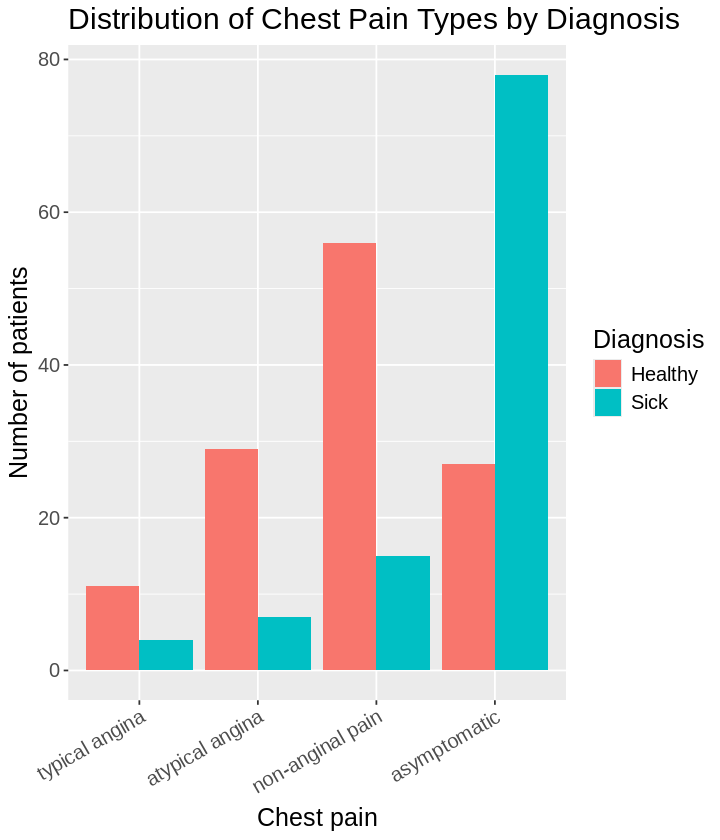

In [4]:
options(repr.plot.width = 6, repr.plot.height = 7)

# Plot with barplot
cp_count <- cleve_training |>
ggplot(aes(x = cp_readable, fill = diagnosis)) +
geom_bar(stat = "count", position = "dodge") +
labs(x = "Chest pain", y = "Number of patients", fill = "Diagnosis", title = "Distribution of Chest Pain Types by Diagnosis") +
theme(axis.text.x = element_text(angle = 30, hjust = 1),
      strip.text.y.left = element_text(angle = 0),
      text = element_text(size = 15))
cp_count

Figure 3

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


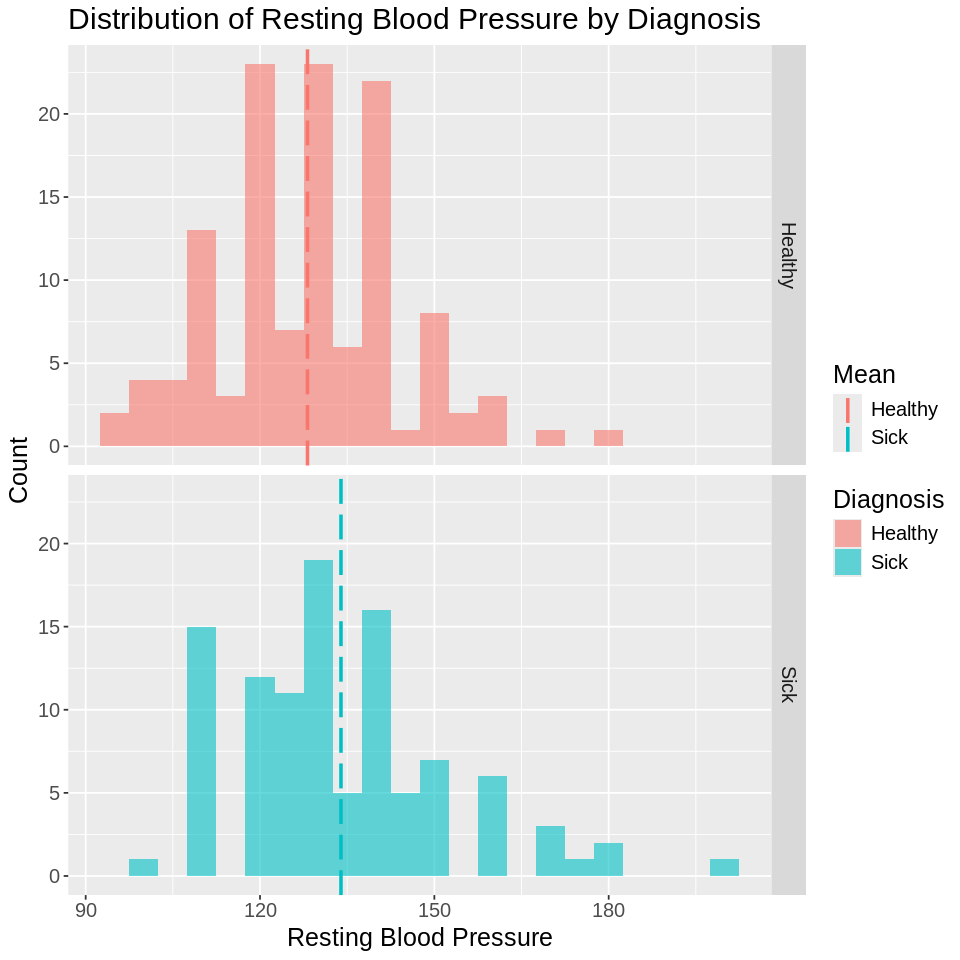

In [5]:
# Calculate means
means <- cleve_training |>
  group_by(diagnosis) |>
  summarize(mean_trestbps = mean(trestbps, na.rm = TRUE),
            mean_chol = mean(chol, na.rm = TRUE))

# Plot with histograms and mean lines
options(repr.plot.width = 8, repr.plot.height = 8)
trestbps_hist <- cleve_training |>
  ggplot(aes(x = trestbps, fill = diagnosis)) +
  geom_histogram(binwidth = 5, alpha = 0.6, position = "identity") +
  geom_vline(data = means, aes(xintercept = mean_trestbps, color = diagnosis), linetype = "longdash", size = 1) +
  facet_grid(row = vars(diagnosis)) +
  labs(
    x = "Resting Blood Pressure",
    y = "Count",
    fill = "Diagnosis",
    color = "Mean", 
    title = "Distribution of Resting Blood Pressure by Diagnosis"
  ) +
  theme(text = element_text(size = 15))

trestbps_hist

Figure 4

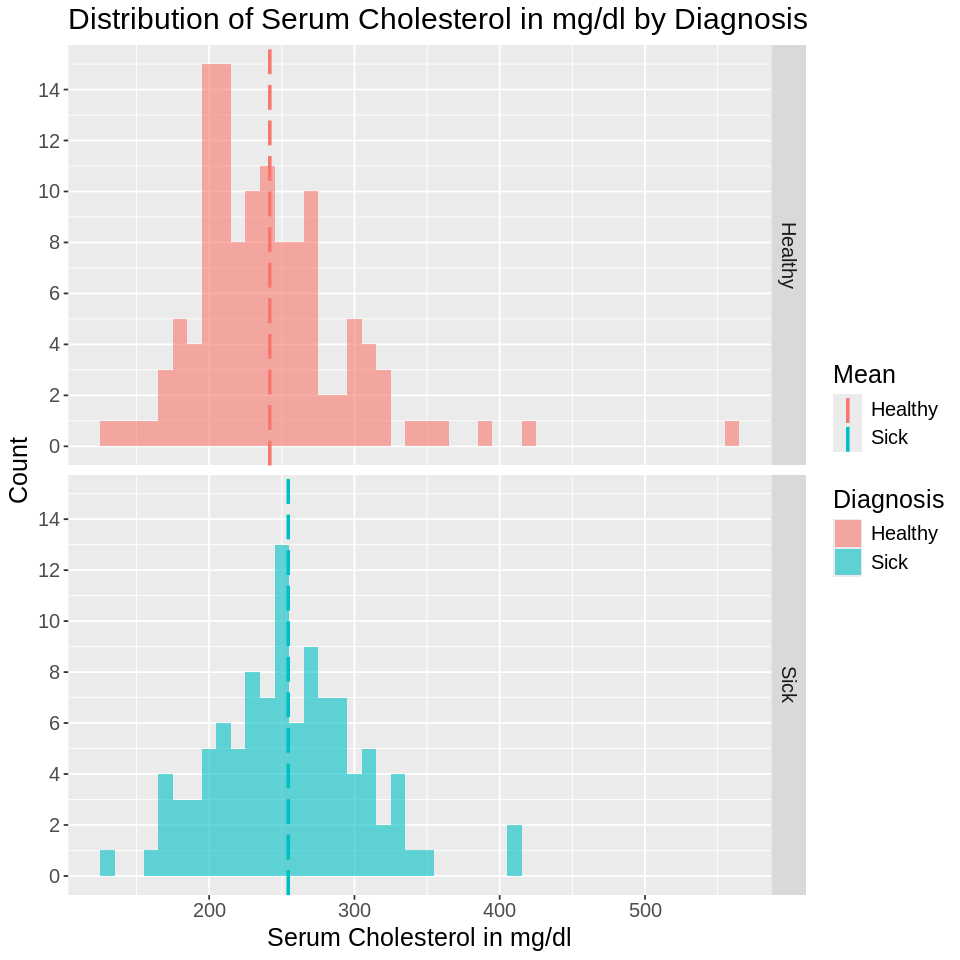

In [6]:
# Plot with histograms and mean lines
options(repr.plot.width = 8, repr.plot.height = 8)
chol_hist <- cleve_training |>
  ggplot(aes(x = chol, fill = diagnosis)) +
  geom_histogram(binwidth = 10, alpha = 0.6, position = "identity") +
  geom_vline(data = means, aes(xintercept = mean_chol, color = diagnosis), linetype = "longdash", size = 1) +
  facet_grid(row = vars(diagnosis)) +
  labs(
    x = "Serum Cholesterol in mg/dl",
    y = "Count",
    fill = "Diagnosis",
    color = "Mean", 
    title = "Distribution of Serum Cholesterol in mg/dl by Diagnosis"
  ) +
  scale_y_continuous(breaks = seq(0, 18, by = 2)) +
  theme(text = element_text(size = 15))

chol_hist

Figure 5

# Methods:
- **Variable Selection**: 
  - Chosen variables: age, trestbps (resting blood pressure), and cholesterol since these variables are relevant indicators of cardiovascular diseases.

- **Classification Model**:
  - Model: k-nearest neighbors (kNN).
  - Weight function: Rectangular (Euclidean distance), which calculates the distance between points.
  - Prediction target: *diagnosis* (categorizes observations as either 'sick' or 'healthy').

- **Data Splitting**:
  - Dataset is divided into two sets with a 75% / 25% split:
    - **Training set**: Used to build and validate the model.
    - **Testing set**: Used to evaluate the model's performance.

- **Cross-Validation**:
  - 5-fold cross-validation with vfold.
    - Partition the training data into 5 folds.
    - Train the model on 4 folds and validate on the remaining fold.
    - Repeat the process 4 more times with the other folds being tested.

- **Tuning the Model**:
  - Determine the best number of neighbors (k).
    - Evaluate different values of k using the training data.
    - Select the k that has the highest accuracy.

- **Model Evaluation**:
  - Once the best k is identified, retrain the model with this k.
  - Test the model on the testing dataset.
  - Use a confusion matrix to summarize the model's results.
  - Assess performance from the confusion matrix:
    - **Accuracy**: Proportion of correctly classified instances.
    - **Recall**: Ability of the model to identify positive cases. This is the **most** important metric we need to look at as it is imperitive to diagnose people who are sick to be sick. In this case, we are making the **sick** classification as **positive**.
    - **Precision**: Proportion of positive identifications that were actually correct.gy clearer and easier to follow.

In [7]:
# Set the seed for reproducibility
set.seed(2024)

# Create a tibble with numbers from 1 to 10 to test which is the best k for the kNN algorithm
cleve_ks <- tibble(neighbors = 1:10)

# Define the kNN model specification with tuning for the number of neighbors
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> # Using the tune() method
    set_engine("kknn") |>
    set_mode("classification") # Mode set to classification because we want to identify whether the patient is sick or not

# Create a 5-fold cross-validation object, stratified by diagnosis
cleve_vfold <- vfold_cv(cleve_training, v = 5, strata = diagnosis)

# Define a recipe for pre-processing the data: scale and center the predictors
cleve_recipe <- recipe(diagnosis ~ trestbps + chol + cp, cleve_training) |>
    step_scale(all_predictors()) |> # Standarizing the data by step_scale and center all predictors. Needed for KNN algorithms to function
    step_center(all_predictors())

# Tune the model to find the best k (number of neighbors)
cleve_best_k <- workflow() |>
    add_recipe(cleve_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cleve_vfold, grid = cleve_ks) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |> # Filter by accuracy of each k value
    arrange(-mean) |>  # Arrange by highest to lowest of the variable mean
    slice(1) |>  # Select the top row (also could've used slice_max)
    select(neighbors) |>  # Select the 'neighbors' column
    pull()  # Extract the value as a vector

# Print the best k found
print(paste("Best k: ", cleve_best_k))

# Define a new kNN model specification using the best k found
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = cleve_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a workflow with the best model specification and fit it to the training data
cleve_fit <- workflow() |>
    add_recipe(cleve_recipe) |>
    add_model(knn_best_spec) |> 
    fit(cleve_training)

# Predict on the testing dataset
cleve_results <- cleve_fit |>
    predict(cleve_testing) |>
    bind_cols(cleve_testing)  # Bind predictions with the testing data

# Generate the confusion matrix to evaluate the model's performance
cleve_conf <- conf_mat(cleve_results, truth = diagnosis, estimate = .pred_class)
cleve_conf

# Manual calculation of performance metrics based on the confusion matrix with seed 2024
# Recall: Proportion of actual positives correctly identified
recall <- 26 / (26 + 9) * 100
print(paste("Recall: ", recall, "%"))

# Accuracy: Proportion of total predictions correctly identified
accuracy <- (31 + 26) / (31 + 26 + 10 + 9) * 100
print(paste("Accuracy: ", accuracy, "%"))

# Precision: Proportion of positive predictions that are actually positive
precision <- 26 / (26 + 10) * 100
print(paste("Precision: ", precision, "%"))

[1] "Best k:  5"


          Truth
Prediction Healthy Sick
   Healthy      31    9
   Sick         10   26

[1] "Recall:  74.2857142857143 %"
[1] "Accuracy:  75 %"
[1] "Precision:  72.2222222222222 %"


Figure 6

# Results

The analysis of the Cleveland Heart Disease Database shows us that the predictors we chose to find cardiovascular disease works pretty well. Key variables, including type of chest pain (cp), cholesterol levels, and resting blood pressure (trestbps), shows significant associations with the likelihood of heart disease.

The k-nearest neighbors (kNN) model, optimized with the best k value of 5, yielded the following performance metrics:

- **Confusion Matrix**:
  - True Positives (Sick correctly predicted as Sick): 26
  - True Negatives (Healthy correctly predicted as Healthy): 31
  - False Positives (Healthy incorrectly predicted as Sick): 10
  - False Negatives (Sick incorrectly predicted as Healthy): 9

- **Performance Metrics**:
  - **Recall**: 74.29%
  - **Accuracy**: 75%
  - **Precision**: 72.22%

These results indicate that the model has a good balance of all the metrics which makes it a fairly good model to effectively distinguishing between healthy and sick individuals. Since recall is the most important metrics we have to look at, 74% recall isn't actually that good. A good model that medical professionals could actually use need a way higher recall and precision than this. In other words, this model isn't good enough to be used in real life; however, it is good enough for this study.

# Expectations and what we've found:

The reason why I chose these predictors are because I believe they are relavent to cardiovascular diseases.

1. **Chest Pain:**
   - Patients experiencing any form of chest pain, such as typical angina or atypical angina, are likely symptoms of cardiovascular disease (Mayo Clinic, 2022). From Figure 3, we can see that there are more people who are actually sick that experience any sort of chest pain. What we found out is that chest pain is relavent to the diagnosis of patients as it demonstrated itself as a good predictor in our model, which what I expected.

2. **Cholesterol Levels**:
   - Elevated cholesterol levels are strongly linked to increased risk of cardiovascular events like heart attacks and strokes. Cholesterol buildup in blood vessels contributes to higher blood pressure and eventually might lead to blood clots. This is another predictor that I was sure that it would be relavent to the diagnosis; according to Figure 4, people who are diagnosied to be sick have a higher average in cholestrol. Since the model preformed pretty well with this predictor, it is safe to say that it is a good predictor.

3. **Resting Blood Pressure (trestbps)**:
   - Higher resting blood pressure is observed more frequently among individuals diagnosed with cardiovascular disease. Elevated blood pressure indicates increased strain on the heart and potential complications. Again, if we look at the visualization in Figure 5, we can see that people who are sick have a higher average in blood pressure. This aligns with what the model found when running it against the testing dataset.
  
Originally I was looking at age to see if it is a good predictor because people who are older are more prone to cardiovascular diseases; however, I found out that it is not a good predictor as it decreased the recall of our model with the same seed. This doesn't really mean that age isn't a good predictor as we could've accidentally just set a bad seed for it.

# Significance
**Implications for Public Health:**

The findings are largely consistent with expectations, confirming that chest pain, cholesterol levels, and blood pressure are pivotal indicators of cardiovascular health. Recognizing these factors as critical warning signs can have huge implications for public health.

By identifying individuals at risk of heart disease through these key indicators, both the public and medical professionals can take measures to mitigate the risk and fatality rate. For the general public, awareness of these risk factors can lead to lifestyle changes such as improved diet and increased physical activity, which are essential for heart health.

Medical professionals can utilize these insights to recommend timely interventions, including regular monitoring and treatment plans. Early detection and preventive strategies can significantly reduce the incidence and severity of cardiovascular events, such as heart attacks and strokes, ultimately saving lives.

**Future Studies:**
Moving forward, exploring additional variables from the database could provide deeper insights into predicting cardiovascular disease more accurately. Investigating factors such as family medical history, diabetes status, body mass index (BMI), and potentially all the other variables we have got from the database that we didn't use could offer a more comprehensive understanding of individual's risk to have an heart attack or a stroke. These variables play important roles in cardiovascular health but were not fully examined in this study. By incorporating these factors into future research, we can refine predictive models and see which are the best predictors to use that gives us the highest recall, precision, and accuracy. We can then have a more comprehensive understanding of cardiovascular diseases as a whole.

# Conclusion

In conclusion, using variables such as chest pain type, cholesterol levels, and resting blood pressure allows for effective prediction of cardiovascular disease. These insights provided by my model support personalized risk assessment and intervention planning. Further research efforts can refine predictive models and expand our understanding of preventive measures against heart disease.

**Bibliogrpahy**

1. Thomas, J. (2024, May 7). Facts and statistics on heart disease. Heart Disease: Facts, Statistics, and You. https://www.healthline.com/health/heart-disease/statistics#:~:text=According%20to%20the%20American%20Heart,compared%20with%2036%25%20of%20men

2. Heart disease - Symptoms and causes - Mayo Clinic. (2022, August 25). Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118 

3. Janosi, Andras, Steinbrunn, William, Pfisterer, Matthias, and Detrano, Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.